In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from tqdm import tqdm, trange
import os

In [3]:
from torch import nn
import torch

In [4]:
path = '../processdata'

In [5]:
mask_img = Image.open(f"{path}/sublabeled/0-0-0-0.tif")
image = np.array(Image.open(f"{path}/suboriginals/0-0-0-0.tif"))

In [6]:
mask = np.array(mask_img)

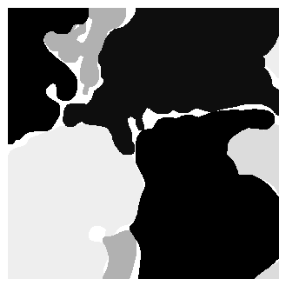

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(mask, cmap = 'gray')
plt.axis('off')
plt.show()
plt.close()

In [8]:
offset = 0.5
def estimate_class(mask):
    # use the average of the grayscale to determine class
    return np.mean(mask[np.where(mask > 0.5)]), np.std(mask[np.where(mask > 0.5)])

In [9]:

mask_coord = np.array(np.meshgrid(np.arange(mask.shape[0]), np.arange(mask.shape[1])))
mask_val = mask * offset

mask_data = np.stack((*mask_coord, mask_val), 0).copy()
flat_points = mask_data.reshape(3,-1).T

normalized_coords = mask_coord / np.max(mask_coord, axis = (1,2)).reshape(2,1,1)

In [10]:
# eps for color distortion
# DBSCAN from sklearn to extract individual masks.
clustering = DBSCAN(eps = 2, min_samples = 9).fit(flat_points)
labels = clustering.labels_

In [11]:
all_mask = []

for i in tqdm(np.unique(labels)[1:]):
    if flat_points[np.where(labels == i)[0],-1].mean() / offset < 245:
        all_mask.append(np.where(labels == i, flat_points[:,-1] / offset, 0).reshape(*mask.shape[:2]))
all_mask = np.array(all_mask)

100%|██████████| 31/31 [00:00<00:00, 3984.66it/s]


In [12]:
# Remove noise points, boundary points and overly small masks.
all_class = np.array(list(map(estimate_class, all_mask)))

valid_class = all_class[np.where(all_class[:,0] < 245)[0]]
valid_mask = all_mask[np.where(all_class[:,0] < 245)[0]]

valid_mask = valid_mask[valid_class[:,1] < 3]
valid_class = valid_class[valid_class[:,1] < 3]
px_thresh = 10
valid_class = valid_class[np.sum((valid_mask > 0.5).astype(int), axis = (1,2)) > px_thresh]
valid_mask = valid_mask[np.sum((valid_mask > 0.5).astype(int), axis = (1,2)) > px_thresh]

valid_mask = (valid_mask > 0.5).astype(int) * valid_class[:,0][:,None, None].astype(int)

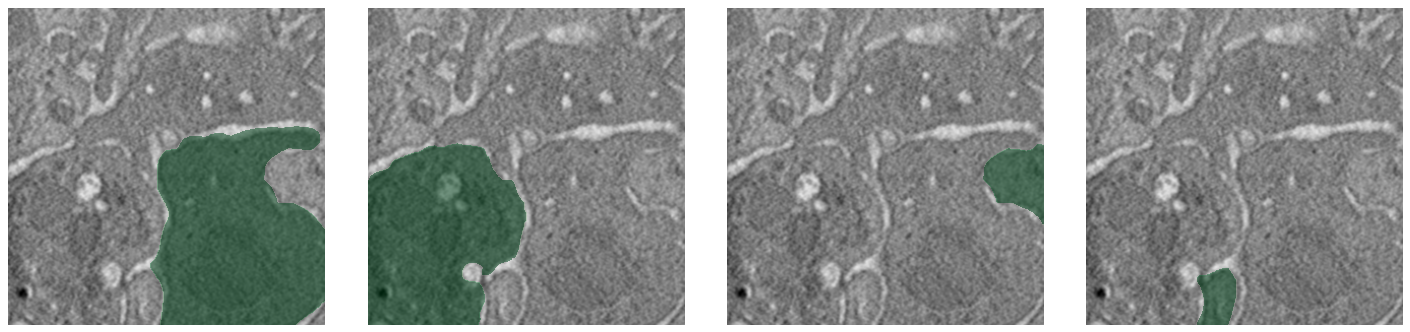

In [13]:
count = 0
plt.figure(figsize = (4 * 5, 5))

for m, c in zip(valid_mask[4:8], valid_class[4:8]):
    
    count += 1

    plt.subplot(1, 4, count)
    plt.imshow(image)
    plt.imshow((m > 0).astype(int), cmap = 'Greens', alpha = (m > 0).astype(int) * 0.5)
    plt.tight_layout()

    plt.axis('off')

plt.savefig('all_mask_example.pdf', dpi = 100)
plt.show()
plt.close()


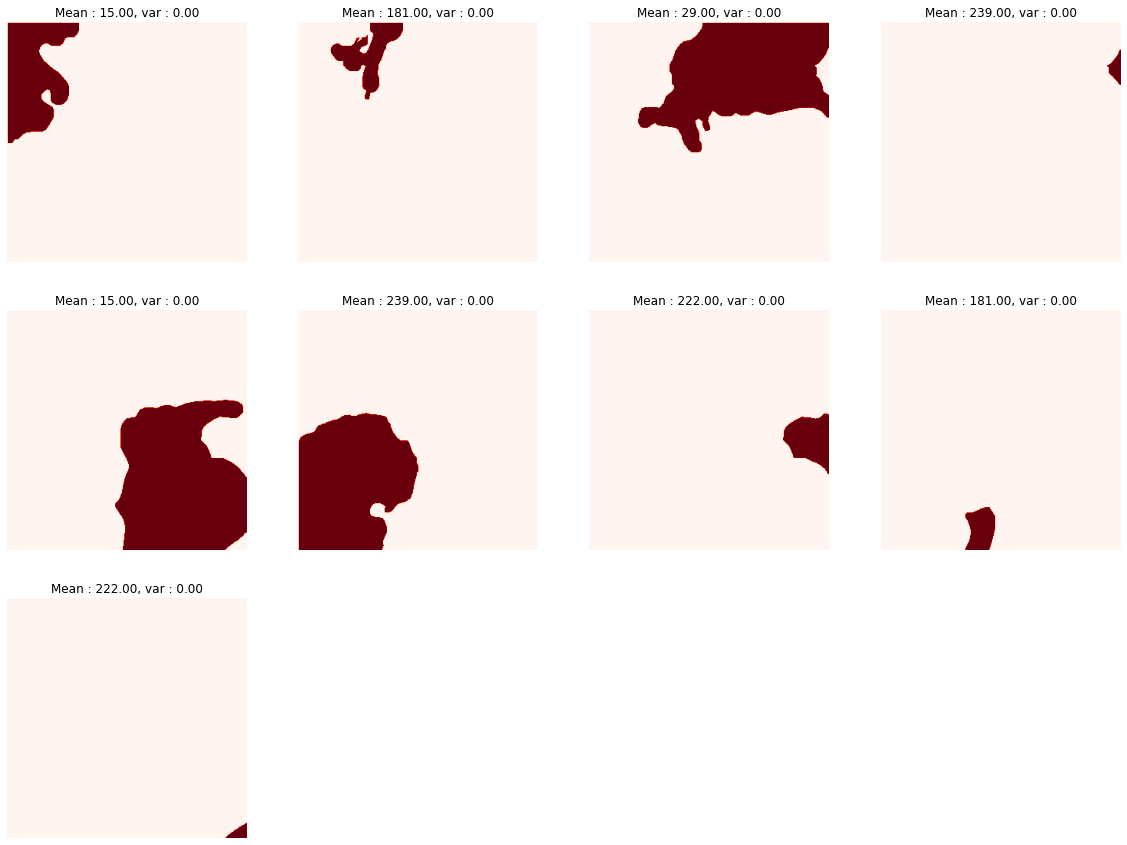

In [14]:
count = 0
plt.figure(figsize = (4 * 5, (valid_mask.shape[0] // 4 + 1) * 5))

for m, c in zip(valid_mask, valid_class):
    
    count += 1

    plt.subplot((valid_mask.shape[0] // 4 + 1), 4, count)
    plt.imshow((m > 0).astype(int), cmap = 'Reds')
    plt.title(f'Mean : {c[0]:.2f}, var : {c[1]:.2f}')

    plt.axis('off')

# plt.savefig('all_mask.pdf', dpi = 100)
plt.show()
plt.close()


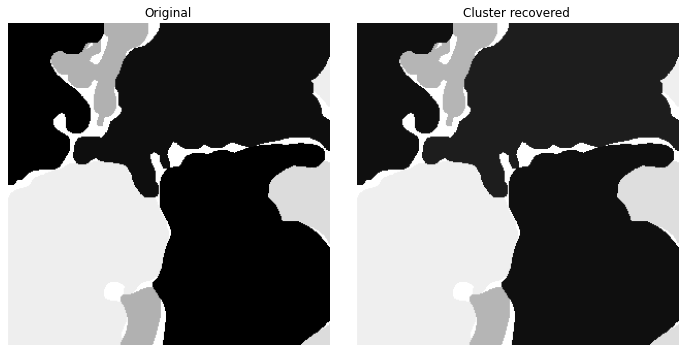

In [26]:
mask_cumulative_sum = np.where(valid_mask.sum(0).astype(int) == 0, 255, valid_mask.sum(0))


plt.figure(figsize = (10,5))


plt.subplot(1,2,1)
plt.imshow(mask, cmap = 'gray')
plt.title('Original')
plt.axis('off')
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(mask_cumulative_sum, cmap = 'gray', vmin=0, vmax=255)
plt.title('Cluster recovered')
plt.axis('off')
plt.tight_layout()

plt.savefig('recovered.pdf', dpi = 100)

plt.show()
plt.close()

In [ ]:
q = np.array([0.001, 0.999])
for t in trange(50):
    for x in range(4):
        for y in range(4):
            file_name = f"0-{x}-{y}-{t}"
            
            mask_file_name = path + "submasks/" + file_name + ".npy"
            bbox_file_name = path + "subbboxes/" + file_name + ".npy"
            
#             if not (os.path.isfile(mask_file_name) and os.path.isfile(bbox_file_name)):
            if True:

                mask_img = Image.open(path + "sublabeled/" + file_name + ".tif")

                mask = np.array(mask_img)

                mask_coord = np.array(np.meshgrid(np.arange(mask.shape[0]), np.arange(mask.shape[1])))
                mask_val = mask * offset

                mask_data = np.stack((*mask_coord, mask_val), 0).copy()
                flat_points = mask_data.reshape(3,-1).T

                normalized_coords = mask_coord / np.max(mask_coord, axis = (1,2)).reshape(2,1,1)

                mask_coord = np.array(np.meshgrid(np.arange(mask.shape[0]), np.arange(mask.shape[1])))
                mask_val = mask * offset

                mask_data = np.stack((*mask_coord, mask_val), 0).copy()
                flat_points = mask_data.reshape(3,-1).T

                clustering = DBSCAN(eps = 2, min_samples = 9).fit(flat_points)
                labels = clustering.labels_

                all_mask = []

                for i in np.unique(labels)[1:]:
                    if flat_points[np.where(labels == i)[0],-1].mean() / offset < 245:
                        all_mask.append(np.where(labels == i, flat_points[:,-1] / offset, 0).reshape(*mask.shape[:2]))
                all_mask = np.array(all_mask)

                all_class = np.array(list(map(estimate_class, all_mask)))

                valid_class = all_class[np.where(all_class[:,0] < 245)[0]]
                valid_mask = all_mask[np.where(all_class[:,0] < 245)[0]]

                valid_mask = valid_mask[valid_class[:,1] < 3]
                valid_class = valid_class[valid_class[:,1] < 3]
                px_thresh = 10
                valid_class = valid_class[np.sum((valid_mask > 0.5).astype(int), axis = (1,2)) > px_thresh]
                valid_mask = valid_mask[np.sum((valid_mask > 0.5).astype(int), axis = (1,2)) > px_thresh]

                valid_mask = (valid_mask > 0.5).astype(int) * valid_class[:,0][:,None, None].astype(int)

                bboxes = []
                # find bounding box
                for m in valid_mask:
                    # dim 0 is column position (x), dim 1 is row position (y)
                    box_coord = normalized_coords.transpose(1,2,0)[m > 0.5]
                    raw_box = np.quantile(box_coord, q = q, axis = 0)
                    b = [raw_box[0,0], raw_box[0,1], raw_box[1,0], raw_box[1,1]]
                    bboxes.append(b.copy())
                bboxes = np.array(bboxes)

                np.save(mask_file_name, (valid_mask > 0.5).astype(int))
                np.save(bbox_file_name, bboxes)
                
                